In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from nltk.collocations import *
from nltk.util import ngrams
from wordcloud import WordCloud
from matplotlib import cm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re, string
from nltk.tag import pos_tag
from tqdm import tqdm
from sklearn.feature_extraction import text

In [68]:
df1 = pd.read_csv('df1_cleaned.csv')
df1 = df1.drop(['Unnamed: 0'], axis=1)

In [69]:
df2 = pd.read_csv('df2_cleaned.csv')
df2 = df2.drop(['Unnamed: 0'], axis=1)

In [70]:
df3 = pd.read_csv('df3_cleaned.csv')
df3 = df3.drop(['Unnamed: 0'], axis=1)

In [71]:
#Merge of the three datasets
frames = [df1, df2, df3]
df = pd.concat(frames)
df = df.drop(['level_0','index'], axis=1)
df = df.reset_index()

In [72]:
#Create a list with all the words in columns 'clean'
word_list = []
for word in df['clean']:
    for i in word_tokenize(str(word)):
        word_list.append(i)

In [73]:
#Create a dictionary with all the different words as key and frequencies as value
dic = {}
for word in word_list:
    if word in dic:
        dic[word] += 1
    else:
        dic[word] = 1

In [74]:
#Create a dictionary with most popularity words
dic2 = {}
for key in dic.keys():
    if dic[key] in [i for i in range(10)]:
        continue
    else:
        dic2[key] = dic[key]

In [75]:
#Create a string object for the dense word cloud
words = ('')
for key in dic2.keys():
    for i in range(1,dic2[key]+1):
        words += key+' '

In [76]:
wordcloud = WordCloud(width=800, height=800, max_words=500, background_color='white', collocations=False,).generate(words)

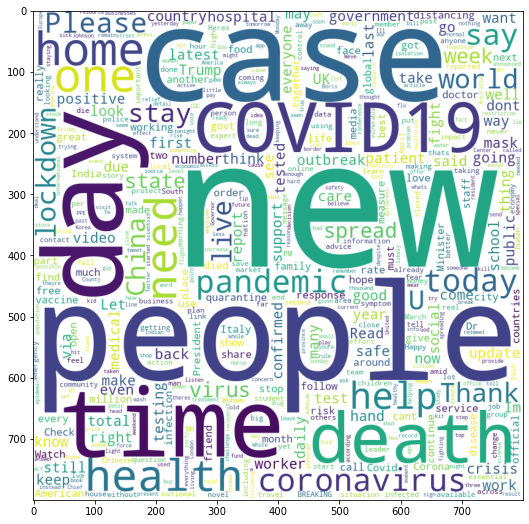

In [77]:
plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.show()

In [78]:
#Sort the dictionary in order to plot the unigram
dic_sorted = dict(sorted(dic2.items(), key=lambda item: item[1], reverse=True))
keys = dic_sorted.keys()
values = dic_sorted.values()

<BarContainer object of 50 artists>

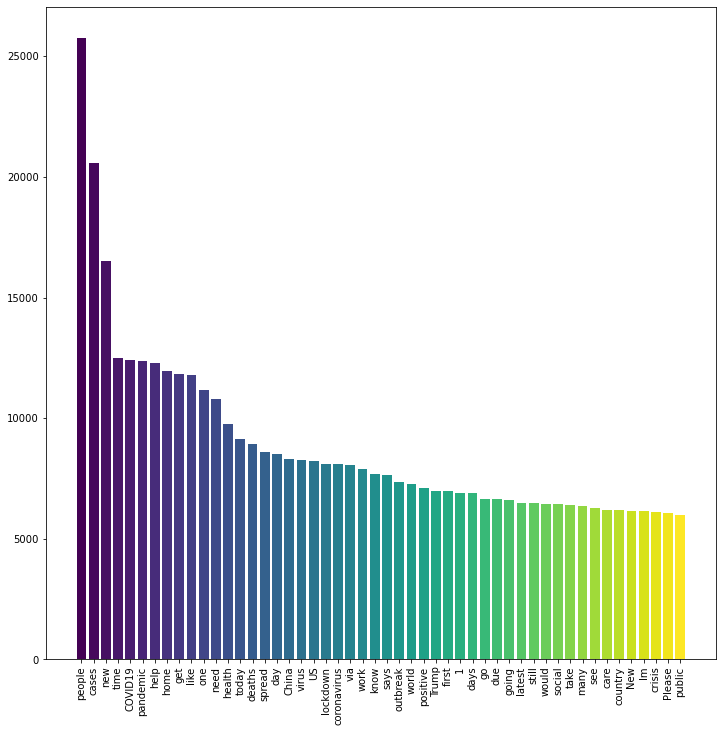

In [79]:
#Plot unigram
viridis = cm.get_cmap('viridis', 50)
newcolors = viridis(np.linspace(0, 1, 50))

plt.figure(figsize=(12,12))
plt.xticks(rotation=90)
plt.bar(list(keys)[0:50], list(values)[0:50], color=newcolors)

In [80]:
#BIGRAMS
bigrams = nltk.bigrams(word_list)
frequence = nltk.FreqDist(bigrams)

In [81]:
#Sort the dictionary
dict_bigram_sorted = dict(sorted(frequence.items(), key=lambda item: item[1], reverse=True))
keys_bigram = dict_bigram_sorted.keys()
values_bigram = dict_bigram_sorted.values()

In [82]:
x = []
for i in keys_bigram:
    x.append('-'.join(i))

<BarContainer object of 50 artists>

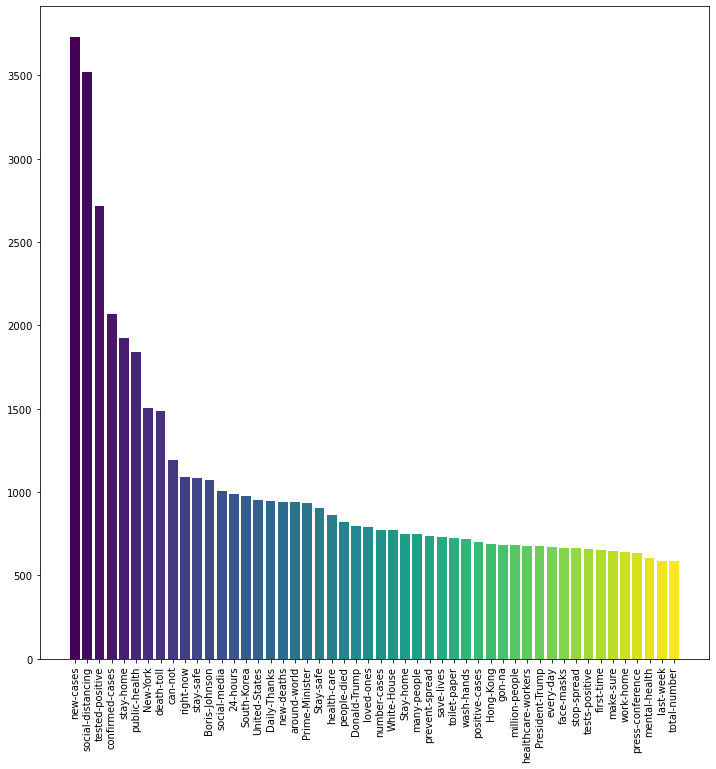

In [83]:
#Plot bigrams
plt.figure(figsize=(12,12))
plt.xticks(rotation=90)
plt.bar(x[0:50], list(values_bigram)[0:50], color=newcolors)

In [84]:
#TRIGRAMS
trigrams = nltk.trigrams(word_list)
frequence2 = nltk.FreqDist(trigrams)

In [85]:
#Sort the dictionary
dict_trigram_sorted = dict(sorted(frequence2.items(), key=lambda item: item[1], reverse=True))
keys_trigram = dict_trigram_sorted.keys()
values_trigram = dict_trigram_sorted.values()

In [86]:
x3 = []
for i in keys_trigram:
    x3.append('-'.join(i))

<BarContainer object of 50 artists>

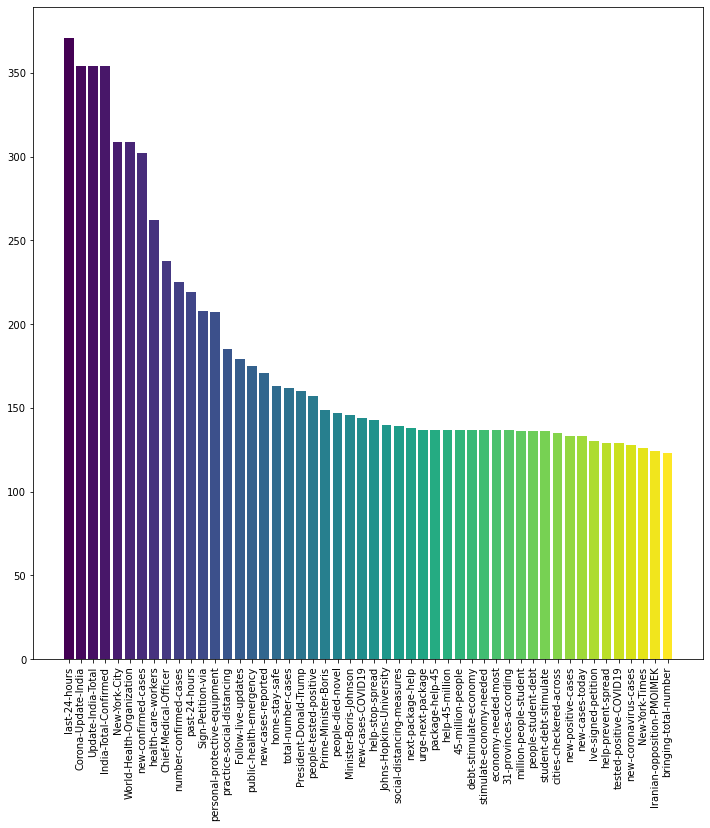

In [87]:
#Plot trigrams
plt.figure(figsize=(12,12))
plt.xticks(rotation=90)
plt.bar(x3[0:50], list(values_trigram)[0:50], color=newcolors)

In [88]:
#VADER
vader = SentimentIntensityAnalyzer()

In [89]:
#Create the list of compund sentiment for each tweet
senti_list = []
for tweet in tqdm(df['clean']):
    tweet = str(tweet)
    compound = vader.polarity_scores(tweet)['compound']
    if compound < 0:
        senti_list.append(0.0) # assigned 0.0 for Negative Tweets
    elif compound > 0:
        senti_list.append(1.0) # assigned 1.0 for Positive Tweets
    else:
        senti_list.append(0.5) # assigned 0.5 for Neutral Tweets

100%|██████████| 301855/301855 [01:15<00:00, 3988.92it/s]


In [90]:
df['compound-senti'] = senti_list

In [91]:
#Percentage of each class
neg = 0
neu = 0
pos = 0
for senti in tqdm(df['compound-senti']):
    if senti==0.0:
        neg += 1
    elif senti==1.0:
        pos += 1
    else:
        neu += 1

tot = neg+neu+pos
perc = [(neg/tot)*100, (pos/tot)*100, (neu/tot)*100]
print('Negative:',round((neg/tot)*100,2),'%', 'Positive:',round((pos/tot)*100,2),'%', 'Neutral:',round((neu/tot)*100,2),'%')

100%|██████████| 301855/301855 [00:00<00:00, 1070354.16it/s]

Negative: 31.27 % Positive: 47.04 % Neutral: 21.69 %


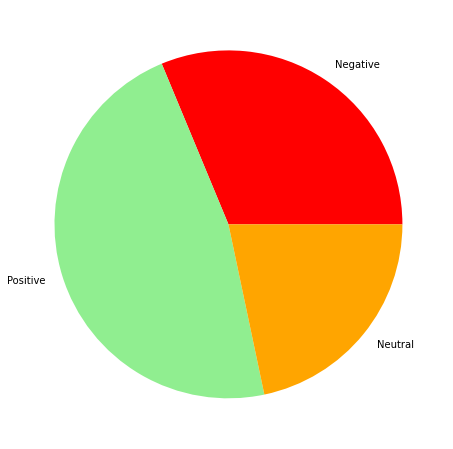

In [92]:
#Plot the pie chart of classes
plt.figure(figsize=(8,8))
plt.pie(perc, labels=['Negative','Positive','Neutral'], colors=['red','lightgreen','orange'])
plt.show()

In [93]:
#Create a new DataFrame with only positive and negative scores
df_final = df.loc[df['compound-senti'] != 0.5 ]

#Drop all columns meaningless
df_final = df_final.drop(['index','id','date','followers','friends','retweets','favorites','entities','sentiment','mentions','hashtags','url','Text'], axis=1)
df_final = df_final.reset_index()

In [94]:
#Save the new dataframe for LSTM
df_final.to_csv('df_for_LSTM.csv')